In [0]:
%matplotlib inline


Adversarial Example Generation
==============================

This tutorial will raise your awareness to the security vulnerabilities
of ML models, and will give insight into the hot topic of adversarial
machine learning. You may be surprised to find that adding imperceptible
perturbations to an image *can* cause drastically different model
performance. Given that this is a tutorial, we will explore the topic
via example on an image classifier. 

Specifically, we will implement a targeted fast gradient signed attack to fool a well-trained SOTA classifier -Inceptionv3 model, trained on Imagenet.

Imagenet for Pytorch: https://pytorch.org/docs/stable/torchvision/datasets.html
Inception V3: https://arxiv.org/abs/1512.00567 





Threat Model
------------
The targeted FGSM attack is a *white-box* attack with a goal of
*misclassification*. 

Fast Gradient Sign Attack
-------------------------

One of the first and most popular adversarial attacks to date is
referred to as the *Targeted Fast Gradient Sign Attack (FGSM)* and is described
by Goodfellow et. al. in  <http://bengio.abracadoudou.com/publications/pdf/kurakin_2017_iclr_physical.pdf>`

The attack is remarkablym powerful, and yet intuitive. It is designed to attack neural networks by leveraging the way they learn--*gradients*. The idea is simple, rather than working to minimize the loss by adjusting the weights based on the backpropagated gradients, the attack *adjusts the input data to maximize
the loss* based on the same backpropagated gradients. In other words,
the attack uses the gradient of the loss w.r.t the input data, then
adjusts the input data to maximize the loss.



 ![alt text](https://miro.medium.com/max/498/1*78UTg3hrRuKP-eOX8yDHMA.png)


$\mathbf{X}$ is the original input image

$J(\mathbf{\theta}, \mathbf{x}, y)$ is the loss
that is used to train the network

$\nabla$ is the gradient

Hopefully now the motivation for this tutorial is clear, so lets jump
into the implementation.


In [0]:
from __future__ import print_function
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from PIL import Image
import numpy as np
import requests, io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from torch.autograd import Variable


In [0]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
my_path = '/content/drive/My Drive/Data/samples/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Implementation
--------------

In this section, we will discuss the input parameters for the tutorial,
define the model under attack, then code the attack and run some tests.


There are only three inputs for this tutorial, and are defined as
follows:

-  **epsilons** - List of epsilon values to use for the run. It is
   important to keep 0 in the list because it represents the model
   performance on the original test set. Also, intuitively we would
   expect the larger the epsilon, the more noticeable the perturbations
   but the more effective the attack in terms of degrading model
   accuracy. Since the data range here is $[0,1]$, no epsilon
   value should exceed 1.

-  **pretrained_model** - path to the pretrained Inception v3 model which was
   trained with Imagenet dataset (1000 classes). You need to load the names of these classes manually.
   




used Dataset
---
The pretrained model we are going to use--InceptionV3--was trained on Imagenet dataset. Thus, we will first load the classes of the dataset. There are 1000 classes here!

In [0]:
# we need to load the classes of the dataset and mapthem to class numbers
labels_link = "https://savan77.github.io/blog/files/labels.json"    
labels_json = requests.get(labels_link).json()
labels = {int(idx):label for idx, label in labels_json.items()}


Model Under Attack
---

As mentioned, the model under attack is the Inception v3 model. Let's load it and load it's pretrained parameters. Make sure that the model is in the evaluation state after loading it.




In [0]:
#download and load pretrained inceptionv3 model
inception = torchvision.models.inception_v3(pretrained=True) 
inception.eval();

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 104M/104M [00:01<00:00, 55.6MB/s] 


In [0]:
# lets explore the model
print(inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

Remember that for using a predefined model, we need to preprocess the inference inputs in the same way the train dataset was processed. 

Here, we need to apply the given transofrmations and they convert the images to tensors. Note that Inception requests images to be of size 299x299

In [0]:
transform = transforms.Compose([
                transforms.Resize((299,299)),  
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

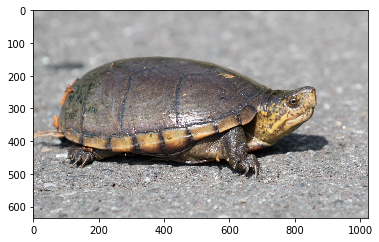

In [0]:
# now let's load an image and run it through the model to learn its label
# I am using an image from my google drive
# let's load and view the image using matplotlib
img = mpimg.imread(my_path+'turtule.jpg') 
plt.imshow(img) 

# need to convert the np array image into PIL image that is acceptable by the transformer
from PIL import Image
img = Image.fromarray(img)

In [0]:
# apply transformer on the image
image_tensor = transform(img)

# reshape the size of the image to match the input size of the model
# remeber that models are trained on batches of images. 
# Thus, they expect input with 4 dimensions batch x channel x H x W
# our image has only three dimensions channel x H x W
print(f'image shape BEFORE reshaping: {image_tensor.shape}')
image_tensor = image_tensor.unsqueeze(0)
print(f'image shape AFTER reshaping: {image_tensor.shape}')


image shape BEFORE reshaping: torch.Size([3, 299, 299])
image shape AFTER reshaping: torch.Size([1, 3, 299, 299])


In [0]:
#convert tensor into a variable
img_variable = torch.autograd.Variable(image_tensor, requires_grad=True) 


In [0]:
output = inception(img_variable)

In [0]:
def top_k_prob(tensor, k=0):
  sorted_probs = tensor.sort(descending=True)[0][0] # returns probailities sorted
  sorted_labels = tensor.sort(descending=True)[1][0] # returns labels sorted accordingly
  return sorted_probs[k], sorted_labels[k]
k=5
prob, label = top_k_prob(output, k) # <----notice top one is 0 !!!!!!!

print(f'Top {k+1} prob:{prob}, class:{label}, label: {labels[label.item()]}')

Top 6 prob:2.41556715965271, class:459, label: brassiere, bra, bandeau


Let's classify this image using pre-trained inceptionv3 model that we just loaded.



In [0]:

#get an index(class number) of a largest element
label_idx = torch.max(output.data, 1)[1][0]   
x_pred = labels[label_idx.item()]
print(f'class: {label_idx.item()} \t label: {labels[label_idx.item()]}')


class: 35 	 label: mud turtle


In [0]:
#get probability dist over classes
output_probs = F.softmax(output, dim=1)
x_pred_prob = torch.max(output_probs.data, 1)[0][0] * 100
print(x_pred_prob.item())

98.1419448852539


Targeted FGSM Attack
-------

Now, we can define the function that creates the adversarial examples by
perturbing the original inputs. The ``fgsm_attack`` function takes three
inputs, *image* is the original clean image ($x$), *epsilon* is
the pixel-wise perturbation amount ($\epsilon$), and *data_grad*
is gradient of the loss w.r.t the input image
($\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y)$). The function
then creates perturbed image as

\begin{align}perturbed\_image = image - epsilon*sign(data\_grad) = x + \epsilon * sign(\nabla_{x} J(\mathbf{x}, Y_{target}))\end{align}

Finally, in order to maintain the original range of the data, the
perturbed image is clipped to range $[0,1]$.




In [0]:
# define a target and cast it to a variable of type tensor
y_target = 459   
y_target = Variable(torch.LongTensor([y_target]), requires_grad=False)
print(f'Target index: {y_target} \t Target label: {labels[y_target.item()]}')

Target index: tensor([459]) 	 Target label: brassiere, bra, bandeau


In [0]:
from torch.autograd.gradcheck import zero_gradients
zero_gradients(img_variable) # reset gradients

loss = torch.nn.CrossEntropyLoss() # define a loss funciton (same used for training the model)

loss_val = loss(output, y_target)
loss_val.backward()

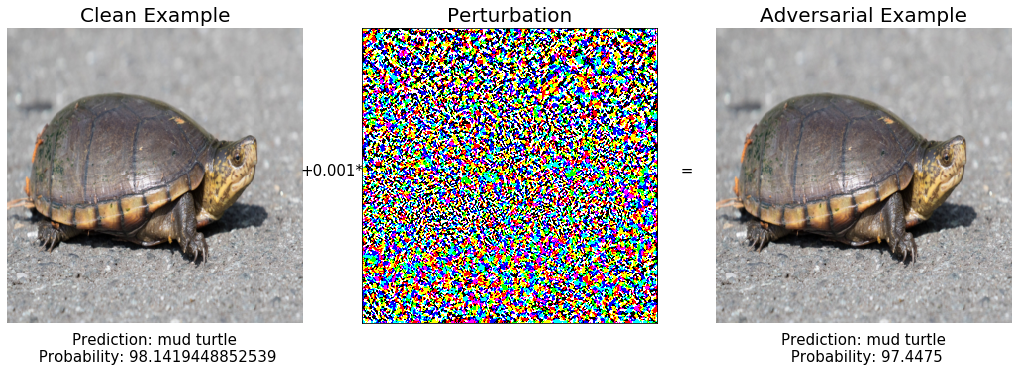

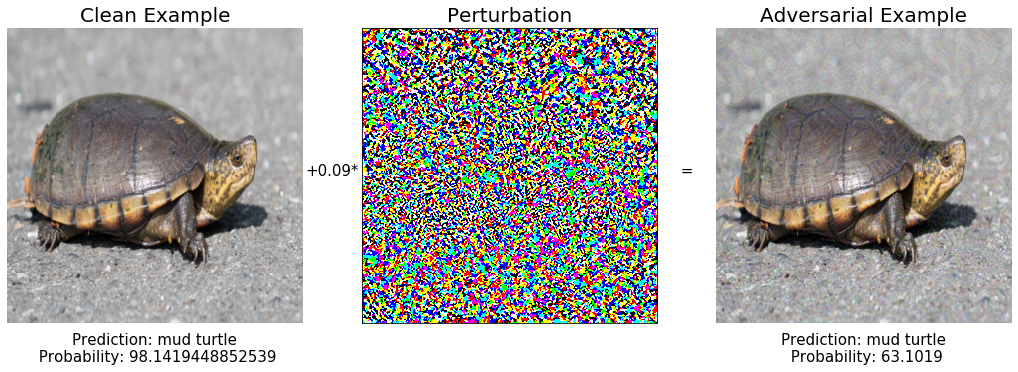

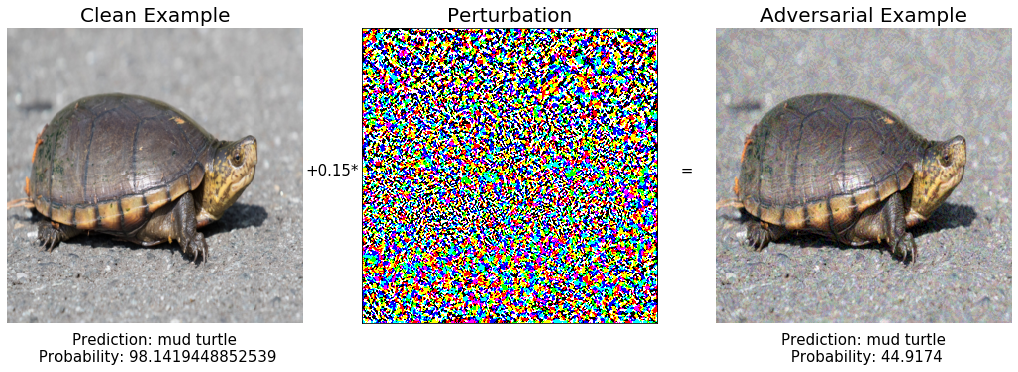

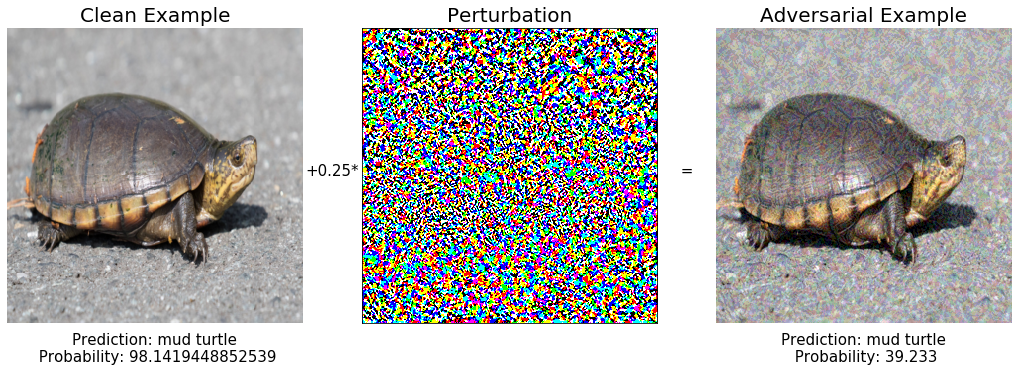

In [0]:
epsilons = [0.001, 0.09, 0.15, 0.25]
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

for i in epsilons:
    x_grad = torch.sign(img_variable.grad.data)

    x_adversarial = img_variable.data - i * x_grad

    
    output_adv = inception.forward(Variable(x_adversarial))
    x_adv_pred = labels[torch.max(output_adv.data, 1)[1][0].item()]
    op_adv_probs = F.softmax(output_adv, dim=1)
    adv_pred_prob =  round((torch.max(op_adv_probs.data, 1)[0][0].item()) * 100, 4)
    visualize(image_tensor, x_adversarial, x_grad, i, x_pred, x_adv_pred, x_pred_prob, adv_pred_prob)



In [0]:
def visualize(x, x_adv, x_grad, epsilon, clean_pred, adv_pred, clean_prob, adv_prob):
    
    x = x.squeeze(0)     #remove batch dimension # B X C H X W ==> C X H X W
    x = x.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).numpy()#reverse of normalization op- "unnormalize"
    x = np.transpose( x , (1,2,0))   # C X H X W  ==>   H X W X C
    x = np.clip(x, 0, 1)
    
    x_adv = x_adv.squeeze(0)
    x_adv = x_adv.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).numpy()#reverse of normalization op
    x_adv = np.transpose( x_adv , (1,2,0))   # C X H X W  ==>   H X W X C
    x_adv = np.clip(x_adv, 0, 1)
    
    x_grad = x_grad.squeeze(0).numpy()
    x_grad = np.transpose(x_grad, (1,2,0))
    x_grad = np.clip(x_grad, 0, 1)
    
    figure, ax = plt.subplots(1,3, figsize=(18,8))
    ax[0].imshow(x)
    ax[0].set_title('Clean Example', fontsize=20)
    
    
    ax[1].imshow(x_grad)
    ax[1].set_title('Perturbation', fontsize=20)
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    
    ax[2].imshow(x_adv)
    ax[2].set_title('Adversarial Example', fontsize=20)
    
    ax[0].axis('off')
    ax[2].axis('off')

    ax[0].text(1.1,0.5, "+{}*".format(round(epsilon,3)), size=15, ha="center", 
             transform=ax[0].transAxes)
    
    ax[0].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(clean_pred, clean_prob), size=15, ha="center", 
         transform=ax[0].transAxes)
    
    ax[1].text(1.1,0.5, " = ", size=15, ha="center", transform=ax[1].transAxes)

    ax[2].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(adv_pred, adv_prob), size=15, ha="center", 
         transform=ax[2].transAxes)
    

    plt.show()

# ICP
---

*   Change the input image and the target